In [1]:
from scipy.stats import ncx2, chi2
from scipy.optimize import minimize
import scipy.special as sc
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate

In [2]:
# global parameters
DIM = 20
eta = 0.05
r_sq = 1.
df = DIM


$$
\mathbb{P} (\| x - \xi \|^2 \leq r)
$$

$$\lambda = \sum x_i^2$$
$$Z = \| x - \xi \|^2$$


$$
\begin{aligned}
\texttt{min } & \exp(-x) \\
\texttt{s.t. } & \mathbb{P} (\| \xi \|^2 + \| x \|^2 \leq r) \geq 1 - \eta
\end{aligned}
$$

# The problem
We would like to assess the performance of different approximation of chance constraints. Namely,

> 1. Markov
> 2. Chebyshev
> 3. Chernoff

The benchmark problem is
$$
\begin{aligned}
    \texttt{min}&~ \exp(-x_1) \\
   \texttt{s.t.}&~ \mathbb{P}(\| \xi \|^2 + \| x \|^2 \leq r^2) \geq 1 - \eta \\
                &~ \xi \sim \mathcal{N}(0, I_d)
\end{aligned}
$$
$\| \cdot \|^2$ is $L_2$ norm
## Ground truth
The ground truth can be revealed easily, noting that $\| \xi \|^2 = \sum_{i = 1}^d \xi_i^2 \sim \chi^2(d)$. Thus,
$$
   \mathbb{P}(\| \xi \|^2 \leq -\| x \|^2 + r^2)  = \texttt{cdf}_{\chi^2(d)}(\| x \|^2).
$$
Due to the symmetry, one can optimize along an axis, for example, along the coordinate $x_1$ and set the rest to be zeroes. So the problem becomes
$$
\begin{aligned}
    \texttt{min}&~ \exp(-x_1) \\
   \texttt{s.t.}&~ \texttt{cdf}_{\chi^2(d)}(-x_1^2 + r^2) \geq 1 - \eta
\end{aligned}
$$
Thus, the solution is $x_1 = \sqrt{r^2 + ~\texttt{cdf}^{-1}_{\chi^2(d)}(1 - \eta)}$


In [3]:
# def GT(df, eta):
#     return chi2(df).ppf(1 - eta)
# GT(df, eta)
def GT(df, eta):
    return r_sq + chi2(df).ppf(1 - eta)
GT(df, eta)

32.41043284423092

# Approximations

## Markov's approximation

For the Markov's approximation we obtain the following optimization problem:
$$
\begin{aligned}
    \texttt{min}&~ \exp(-x_1) \\
   \texttt{s.t.}&~ \mathbb{E}\left(\| \xi \|^2 + \| x \|^2 - r^2 + t\right)_+ \leq \eta t \\
                &~ \xi \sim \mathcal{N}(0, I_d)
\end{aligned}
$$
Applying the same logic for optimization along axis $x_1$ and denoting $\| \xi \|^2 = Z \sim \chi^2(d)$, we can write the problem as follows:
$$
\begin{aligned}
    \texttt{min}&~ \exp(- x_1) \\
   \texttt{s.t.}&~ \mathbb{E}\left(Z + x_1^2 - r^2 + t\right)_+ \leq \eta t \\
                &~ Z \sim \chi^2(d)
\end{aligned}
$$
The expectation can be expanded as follows:
$$
\begin{aligned}
\mathbb{E}\left(Z + x_1^2 - r^2 + t\right)_+ &= \int_{-x_1^2 - t + r^2}^{\infty} (z + x_1^2 - r^2 + t)f_{\chi^2(d)}(z)dz \\
                                       &=\left(t + x_1^2 - r^2\right) \left(1 - cdf_{\chi^2(d)}(t + x_1^2 - r^2) \right) +\int_{-x_1^2 - t + r^2}^{\infty} z f_{\chi^2(d)}(z)dz \\ 
                                       &=\left(t + x_1^2 - r^2\right) \left(1 - cdf_{\chi^2(d)}(t + x_1^2 - r^2) \right) +\frac{\Gamma(d + 1, -x_1^2 - t + r^2)}{2^{d / 2} \cdot \Gamma(d / 2)},
\end{aligned}
$$
where $\Gamma(s, x) = \int_x^{\infty} x^{s - 1}e^{- x/2}dx$ -- upper incomplete gamma function.
Thus, we are to solve the following problem:
$$
\begin{aligned}
    \texttt{min}&~ \exp(- x_1) \\
   \texttt{s.t.}&~ \left(t + x_1^2 - r^2\right) \left(1 - cdf_{\chi^2(d)}(t + x_1^2 - r^2) \right) +\frac{\Gamma(d + 1, -x_1^2 - t + r^2)}{2^{d / 2} \cdot \Gamma(d / 2)} \leq \eta t 
\end{aligned}
$$
Again, we are aiming at reaching the equality in the constraint:
$$
x^* = (x_1, 0,\dots, 0), ~ x_1: ~ \left(t + x_1^2 - r^2\right) \left(1 - cdf_{\chi^2(d)}(t + x_1^2 - r^2) \right) +\frac{\Gamma(d + 1, -x_1^2 - t + r^2)}{2^{d / 2} \cdot \Gamma(d / 2)} = \eta t 
$$
Note that we assume PDF and CDF of $\chi^2$ to be zero for negative arguments.

In [4]:
def tail_E(df, x_1, t, r_sq):
    result = sc.gammainc(df + 1, -x_1**2 - t + r_sq) * sc.gamma(df + 1)
    return result
def markov_FT(df, x_1, t, r_sq):
    return (t + x_1 ** 2 - r_sq) * (1 - chi2(df).cdf(t + x_1 ** 2 - r_sq))

In [5]:
def markov_residual(df, eta, x_1, t, r_sq):
    return (markov_FT(df, x_1, t, r_sq) + tail_E(df, x_1, t, r_sq) - eta * t) ** 2


In [6]:
x_0 = [0.9, 0]
def markov_approx(df, eta, r_sq, x_0):
    foo = lambda x: markov_residual(df, eta, x[0], x[1], r_sq)
    res = minimize(fun = foo, x0 = x_0, method = 'Nelder-Mead')
    #print(res.fun)
    return res.x[0]
M = markov_approx(df, eta, r_sq, x_0)
M

0.9999323272705078

In [7]:
def plot_cmp(approx_foo, name):
    #plt.figure(figsize=(10, 7))
    ds = list(range(2, 50))
    x_0 = [0.9, 0.1]
    ys = [GT(df, eta) / approx_foo(d, eta, r_sq, x_0) for d in ds]
    plt.title(name)
    plt.ylabel(r'GT / approx')
    plt.xlabel('dimensionality')
    plt.plot(ds, ys, label = str(eta))
    #plt.show()
    return ds, ys


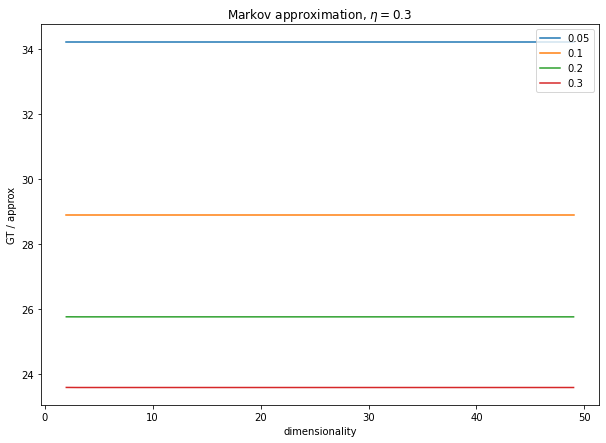

In [8]:
plt.figure(figsize=(10, 7))
for et in [0.05, 0.1, 0.2, 0.3]:
    eta = et
    ds_markov, ys_markov = plot_cmp(markov_approx, r'Markov approximation, $\eta = $'+str(eta))
plt.legend()
plt.show()

## Chebyshev's approximation

For the Chebyshev's approximation we obtain the following optimization problem:
$$
\begin{aligned}
    \texttt{min}&~ \exp(-x_1) \\
   \texttt{s.t.}&~ \mathbb{E}\left(\| \xi \|^2 + \| x \|^2 - r^2 + t\right)^2_+ \leq \eta t^2 \\
                &~ \xi \sim \mathcal{N}(0, I_d)
\end{aligned}
$$
Applying the same logic for optimization along axis $x_1$ and denoting $\| \xi \|^2 = Z \sim \chi^2(d)$, we can write the problem as follows:
$$
\begin{aligned}
    \texttt{min}&~ exp(-x_1) \\
   \texttt{s.t.}&~ \mathbb{E}\left(Z + x_1^2 - r^2 + t\right)^2_+ \leq \eta t^2 \\
                &~ Z \sim \chi^2(d)
\end{aligned}
$$
The expectation can be expanded as follows:
$$
\begin{aligned}
\mathbb{E}\left(Z + x_1^2 - r^2 + t\right)^2_+ &= \int_{-x_1^2 - t + r^2}^{\infty} z^2 f_{\chi^2(d)}(z) dz - 2 (-x_1^2 - t + r^2) \int_{-x_1^2 - t + r^2}^{\infty} z f_{\chi^2(d)}(z) dz + (t + x_1^2 - r^2)^2 \left( 1 - \texttt{cdf}_{\chi^2(d)}(t + x_1^2 - r^2) \right) \\
                                         &= \frac{\Gamma(d + 2, -x_1^2 - t + r^2)}{2^{d / 2} \cdot \Gamma(d / 2)} - 2 (-x_1^2 - t + r^2) \frac{\Gamma(d + 1, -x_1^2 - t + r^2)}{2^{d / 2} \cdot \Gamma(d / 2)} + (-t - x_1^2 + r^2)^2 \left( 1 - \texttt{cdf}_{\chi^2(d)}(t + x_1^2 - r^2) \right)
\end{aligned}
$$
Thus, we are to solve the following problem:
$$
\begin{aligned}
    \texttt{min}&~ \exp(-x_1) \\
   \texttt{s.t.}&~ \frac{\Gamma(d + 2, -x_1^2 - t + r^2)}{2^{d / 2} \cdot \Gamma(d / 2)} - 2 (-x_1^2 - t + r^2) \frac{\Gamma(d + 1, -x_1^2 - t + r^2)}{2^{d / 2} \cdot \Gamma(d / 2)} + (-t - x_1^2 + r^2)^2 \left( 1 - \texttt{cdf}_{\chi^2(d)}(-t - x_1^2 + r^2) \right) \leq \eta t^2
\end{aligned}
$$
Again, we are aiming at reaching the equality in the constraint:
$$
x^* = (x_1, 0,\dots, 0), ~ x_1: ~ \frac{\Gamma(d + 2,- x_1^2 - t + r^2)}{2^{d / 2} \cdot \Gamma(d / 2)} - 2 ( - x_1^2 - t + r^2) \frac{\Gamma(d + 1, -x_1^2 - t + r^2)}{2^{d / 2} \cdot \Gamma(d / 2)} + (t + x_1^2 - r^2)^2 \left( 1 - \texttt{cdf}_{\chi^2(d)}(t + x_1^2 - r^2) \right) = \eta t^2
$$
Note that we assume PDF and CDF of $\chi^2$ to be zero for negative arguments.

In [9]:
def tail_E_che(df, x_1, t, r_sq):
    result = sc.gammainc(df + 1, -x_1**2 - t + r_sq) * sc.gamma(df + 1)
    return - 2 * (-x_1**2 - t + r_sq) * result

def tail_V_che(df, x_1, t, r_sq):
    result = sc.gammainc(df + 2, - x_1**2 - t + r_sq) * sc.gamma(df + 2)
    return result 

def che_FT(df, x_1, t, r_sq):
    return (-t - x_1 ** 2 + r_sq ) ** 2 * (1 - chi2(df).cdf(t + x_1 ** 2 - r_sq))

def che_residual(df, eta, r_sq, x_1, t):
    return (che_FT(df, x_1, t, r_sq) + tail_E_che(df, x_1, t, r_sq) + tail_V_che(df, x_1, t, r_sq) - eta * t ** 2) ** 2

x_0 = [0., 0.]
def che_approx(df, eta, r_sq, x_0):
    foo = lambda x: che_residual(df, eta, r_sq, x[0], x[1])
    res = minimize(fun = foo, x0 = x_0, method = 'Nelder-Mead')
    #print(res.fun)
    return res.x[0]



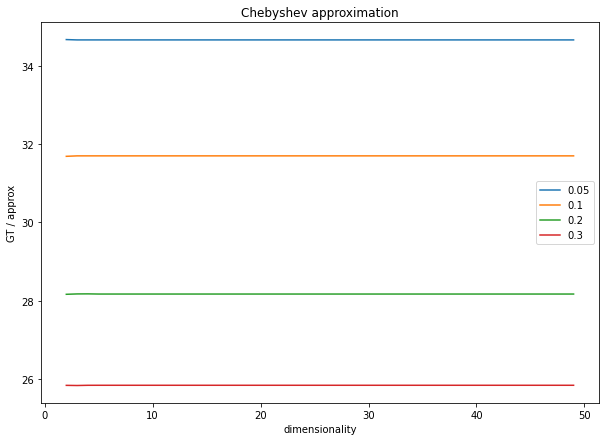

In [10]:
plt.figure(figsize=(10, 7))
for et in [0.05, 0.1, 0.2, 0.3]:
    eta = et
    ds_cheb, ys_cheb = plot_cmp(che_approx, r'Chebyshev approximation')
plt.legend()
plt.show()

## Chernoff's approximation

For the Chernoff's approximation we obtain the following optimization problem:
$$
\begin{aligned}
    \texttt{min}&~ \exp(- x_1) \\
   \texttt{s.t.}&~ \log \mathbb{E} \exp \left( \left(\| \xi \|^2 + \| x \|^2 - r^2\right) / t \right) \leq \log \eta.
\end{aligned}
$$
Let us rewrite the LHS of the inequality, bearing in mind the logic with $x_1$:
$$
\log \mathbb{E} \exp \left( \left(\| \xi \|^2 + \| x \|^2 - r^2\right) / t \right) = \frac{x_1^2 - r^2}{t} + \log \mathbb{E} \exp\left(\frac{\| \xi \|^2}{t}\right)
$$
The expectation in the LHS is the cumulat generating function of $\| \xi \|^2 = Z \sim \chi^2(d)$ evaluated at $t$. Thus, incorporating cumulant generating function, we can rewrite the constraint as follows:
$$
\frac{x_1^2 - r^2}{t} + (1 - 2t)^{-d / 2} \leq \log \eta.
$$
Again, we can work with only one component $x_1$.
Summing up, the optimization problem to solve is
$$
\begin{aligned}
    \texttt{min}&~ - x_1^2 \\
   \texttt{s.t.}&~ \frac{x_1^2 - r^2}{t} + (1 - 2t)^{-d / 2} \leq \log \eta.
\end{aligned}
$$

In [11]:
def lhs_chernoff(df, x_1, t, eta, r_sq):
    first = (x_1**2 - r_sq) / t
    second = (1 - 2 * t) ** (- df / 2)
    return first + second

def chernoff_residual(df, eta, x_1, t, r_sq):
    return (lhs_chernoff(df, x_1, t, eta, r_sq) - np.log(eta)) ** 2

x_0 = [0.9, 0.4]
def chernoff_approx(df, eta, r_sq, x_0,):
    foo = lambda x: chernoff_residual(df, eta, x[0], x[1], r_sq)
    return minimize(fun = foo, x0 = x_0, method = 'Nelder-Mead').x[0]
chernoff_approx(df, 0.05, r_sq, x_0)

1.8990241018799474

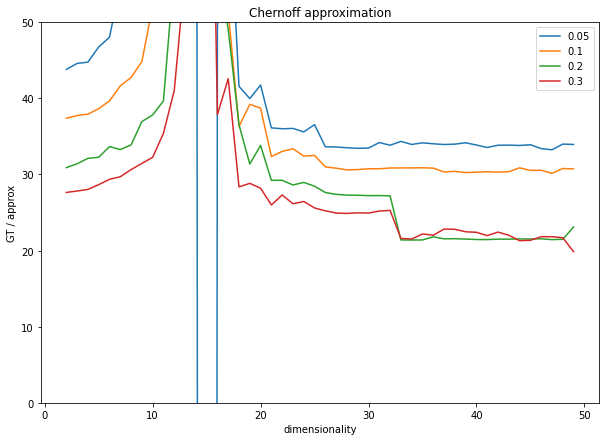

In [12]:
plt.figure(figsize=(10, 7))
for et in [0.05, 0.1, 0.2, 0.3]:
    eta = et
    ds_cher, ys_cher = plot_cmp(chernoff_approx, r'Chernoff approximation')
plt.ylim(0, 50)
plt.legend()
plt.show()

## Together

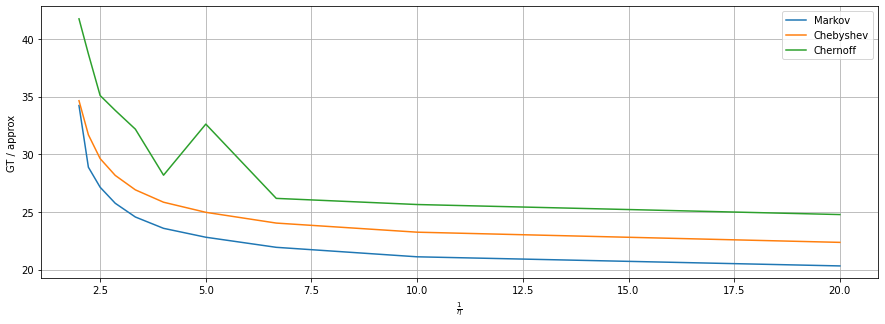

In [19]:
def plot_cmp_etas(approx_foos, names):
    etas = np.linspace(0.05, 0.5, 10)
    plt.figure(figsize=(15, 5))
    for i in range(len(approx_foos)):
        ys = []
        for et in etas:
            eta = et
            x_0 = [0.9, 0.1]
            ys.append(GT(df, eta) / approx_foos[i](df, eta, r_sq, x_0))
        plt.plot(1 / etas, ys[::-1], label=names[i])
        #plt.semilogy(etas, ys, label=names[i])
    plt.ylabel(r'GT / approx')
    plt.xlabel(r'$\frac{1}{\eta}$')
    plt.grid()
    plt.legend()
    plt.savefig('approx_cmp_mv.jpg')
    plt.show()
    
    
plot_cmp_etas([markov_approx, che_approx, chernoff_approx], ['Markov', 'Chebyshev', 'Chernoff'])